In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [3]:

function check_phase(matrix)
    in_phase = diag(matrix)
    anti_phase = diag(matrix, convert(Int, round(n_x / 2)))

    v1 = reduce(*, map(x -> x > 1.0 - epsilon, in_phase))
    v2 = reduce(*, map(x -> x < -1.0 + epsilon, anti_phase))
    return v1, v2
end

check_phase (generic function with 1 method)

In [4]:
using DifferentialEquations

In [5]:
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025
solver_args = Dict(:adaptive => false, :dt => 0.01, :abstol => 1e-6, :reltol => 1e-6)
spk_args = SpikingArgs(t_window = 0.01, 
                    threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)
tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

1001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1
  0.11
  0.12
  ⋮
  9.89
  9.9
  9.91
  9.92
  9.93
  9.94
  9.95
  9.96
  9.97
  9.98
  9.99
 10.0

In [6]:
phase_x = reshape(range(-1.0, 1.0, n_x), (1, n_x, n_vsa)) |> collect
phase_y = reshape(range(-1.0, 1.0, n_y), (1, n_y, n_vsa)) |> collect

1×101×1 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  1.0

In [7]:
sims = similarity_outer(phase_x, phase_y, dims= 2, reduce_dim=1)[1,1,:,:]
v1, v2 = check_phase(sims)

(true, true)

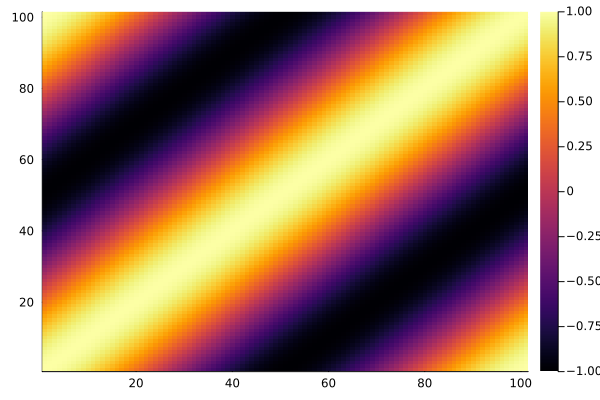

In [8]:
heatmap(sims)

In [9]:
import .PhasorNetworks: phase_to_train

In [10]:
function phase_to_train(phases::AbstractArray; spk_args::SpikingArgs, repeats::Int = 1, offset::Real = 0.0)
    shape = phases |> size
    indices = collect(CartesianIndices(shape)) |> vec
    times = phase_to_time(phases, spk_args=spk_args, offset=offset) |> vec

    if repeats > 1
        n_t = times |> length
        offsets = repeat(0:repeats-1, inner=n_t)
        times = repeat(times, repeats) .+ offsets
        indices = repeat(indices, repeats)
    end

    train = SpikeTrain(indices, times, shape, offset)
    return train
end

phase_to_train (generic function with 1 method)

In [11]:
st_x = phase_to_train(phase_x, spk_args = spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args = spk_args, repeats = repeats)

Spike Train: (1, 101, 1) with 1010 spikes.

In [143]:
sims_2 = stack(similarity_outer(st_x, st_y, dims=2, reduce_dim=3, tspan=tspan, spk_args = spk_args));

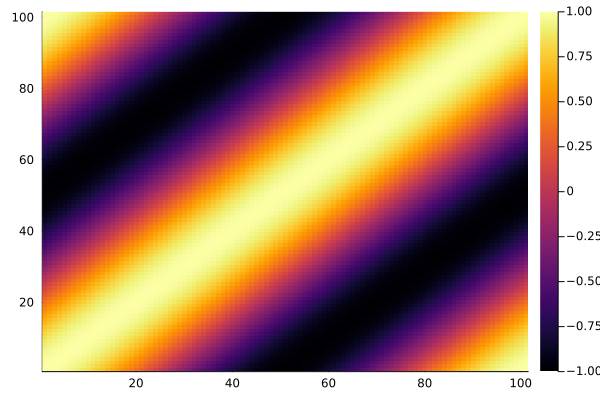

In [13]:
heatmap(sims_2[1,1,500,:,:])

In [14]:
size(sims_2)

(1, 1, 1001, 101, 101)

In [15]:
spk_chks = mapslices(x -> check_phase(x), sims_2, dims=(4,5)) |> vec

1001-element Vector{Tuple{Bool, Bool}}:
 (0, 1)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 ⋮
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)
 (1, 1)

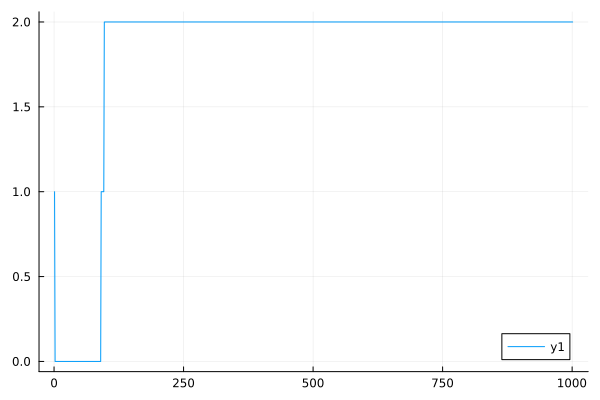

In [16]:
plot(sum.(spk_chks))

In [147]:
acc_t = mapslices(x -> cor_realvals(vec(sims), vec(x)), sims_2, dims=(4,5)) |> vec;

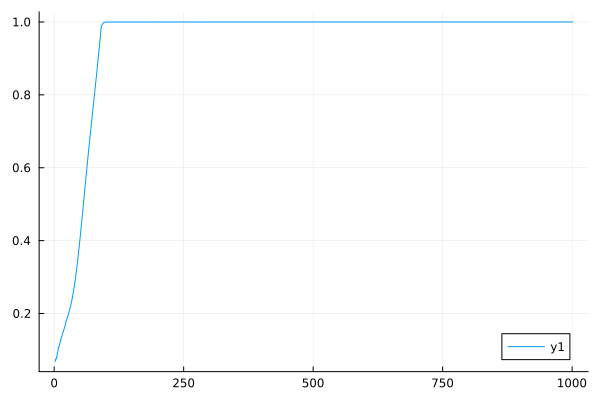

In [148]:
plot(acc_t)

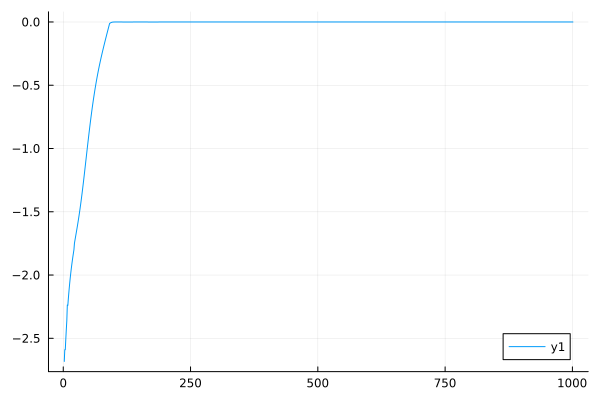

In [19]:
plot(log.(acc_t))

In [114]:
du = 0.1

0.1

In [115]:
rv = stack([[i,j] for i in -1.0:du:1.0, j in -1.0:du:1.0]);

In [116]:
s = realvec_to_cmpx(rv);

In [117]:
scatter(real.(vec(s)), imag.(vec(s)));

In [118]:
sr = cmpx_to_realvec(s);

In [119]:
ss = realvec_to_cmpx(sr);

In [120]:
reduce(*, ss .== s)

true

In [130]:
cmpx_to_realvec(s);

In [122]:
nn_fn = Chain(x -> cmpx_to_realvec(x),
                Dense(2 => 32, relu),
                Dense(32 => 64, relu),
                Dense(64 => 2),
                x -> realvec_to_cmpx(x))

Chain(
    layer_1 = WrappedFunction{:direct_call}(var"#30#32"()),
    layer_2 = Dense(2 => 32, relu),     # 96 parameters
    layer_3 = Dense(32 => 64, relu),    # 2_112 parameters
    layer_4 = Dense(64 => 2),           # 130 parameters
    layer_5 = WrappedFunction{:direct_call}(var"#31#33"()),
)         # Total: 2_338 parameters,
          #        plus 0 states.

In [123]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, nn_fn)

((layer_1 = NamedTuple(), layer_2 = (weight = Float32[-0.038242 -0.018462978; -0.27425224 -0.3974123; … ; 0.04629824 0.2983686; 0.103044234 0.36587718], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.16007057 -0.020660251 … 0.060460716 -0.11303857; -0.03887078 -0.046356976 … -0.24493301 -0.19469672; … ; 0.019833654 0.13936102 … -0.16052324 -0.21440983; 0.027048767 -0.09485188 … -0.108050495 0.12579134], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_4 = (weight = Float32[0.22279963 -0.043489106 … -0.24192627 0.20324627; 0.03205522 0.19575682 … 0.090184174 -0.26031214], bias = Float32[0.0; 0.0;;]), layer_5 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [124]:
du0, _ = nn_fn(s, ps, st)

(ComplexF64[-0.10268082774609677 - 0.2278792719095227im -0.08829973646725969 - 0.2129866990799162im … 0.0762938963203679 - 0.008559131842843211im 0.08695533992675658 - 0.011407254564363202im; -0.11081056054586813 - 0.21984661801276525im -0.09241274497148706 - 0.20509134471857052im … 0.07825980593408094 - 0.010266529107926942im 0.0858132278355222 - 0.018640453075025157im; … ; -0.07838890675483745 - 0.14315448902923114im -0.07238200045900761 - 0.13096455543462235im … -0.0020676108593184316 - 0.11719050312602351im 0.002019531330960863 - 0.11237091005912621im; -0.08042444495445288 - 0.1455161727051359im -0.07152804070869277 - 0.13417102312817164im … -0.0025184664063110335 - 0.12761706307017157im -0.002297345399242718 - 0.13021167014002613im], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [131]:
nn_fn2 = StatefulLuxLayer(nn_fn, st)

StatefulLuxLayer{true}(
    Chain(
        layer_1 = WrappedFunction{:direct_call}(var"#30#32"()),
        layer_2 = Dense(2 => 32, relu),  # 96 parameters
        layer_3 = Dense(32 => 64, relu),  # 2_112 parameters
        layer_4 = Dense(64 => 2),       # 130 parameters
        layer_5 = WrappedFunction{:direct_call}(var"#31#33"()),
    ),
)         # Total: 2_338 parameters,
          #        plus 0 states.

In [125]:
size(du0)

(21, 21)

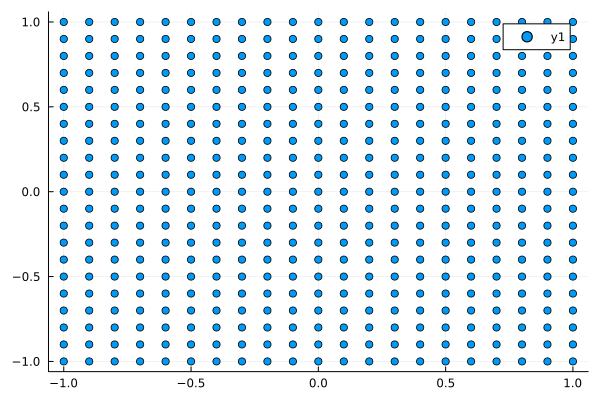

In [126]:
scatter(real.(vec(s)), imag.(vec(s)))

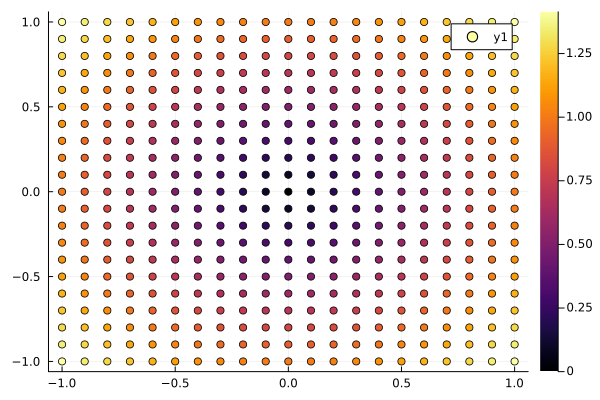

attempt to save state beyond implementation limit


In [127]:
scatter(real.(vec(s)), imag.(vec(s)), marker_z = abs.(vec(s)))

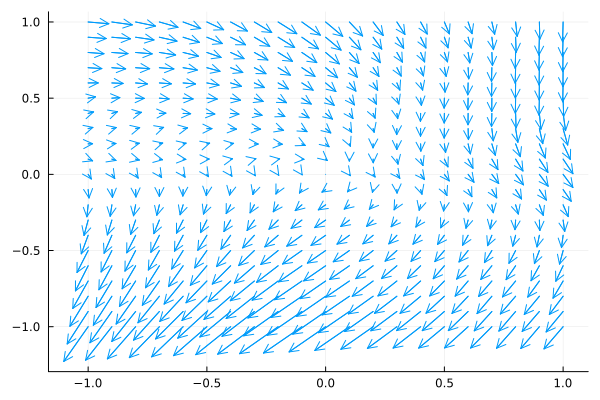

In [129]:
quiver(real.(vec(s)), imag.(vec(s)), quiver=(real.(vec(du0)), imag.(vec(du0))))

In [137]:
import .PhasorNetworks: neuron_constant

In [138]:
spk_args2 = SpikingArgs(t_window = 0.01, 
                    threshold = 0.001,
                    solver=Tsit5(), 
                    update_fn = u -> neuron_constant(spk_args.leakage, spk_args.t_period) .* u 
                        .+ nn_fn2(u, ps),
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [140]:
sims_3 = stack(similarity_outer(st_x, st_y, dims=2, reduce_dim=3, tspan=tspan, spk_args = spk_args2));

In [150]:
acc_t2 = mapslices(x -> cor_realvals(vec(sims), vec(x)), sims_3, dims=(4,5)) |> vec;

In [146]:
reduce(*, sims_3 .== sims_2)

false

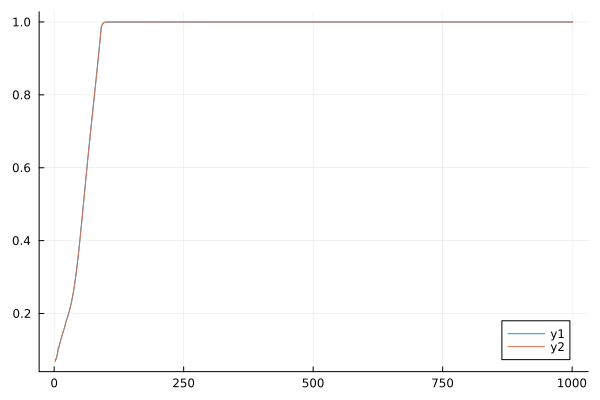

In [151]:
plot(acc_t)
plot!(acc_t2)